In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import plotly.graph_objects as go

def plot_xyz_csv(
    csv_path: str,
    time_col: str = "ts",
    value_cols: tuple[str, str, str] = ("x", "y", "z"),
    title: str | None = None,
    show: bool = True,
    round_stats: int = 6,
):
    """
    Read a CSV with columns [ts, x, y, z], plot x/y/z over time with Plotly,
    and compute per-axis statistics (min, max, mean, std).

    Returns a dict with:
      - 'df': cleaned dataframe
      - 'stats': DataFrame of statistics (per axis)
      - 'fig': plotly Figure
    """
    path = Path(csv_path)
    if not path.exists():
        raise FileNotFoundError(f"File not found: {csv_path}")


    df = pd.read_csv(csv_path, sep=None, engine="python")


    cols_lower = {c.lower(): c for c in df.columns}
    if time_col.lower() not in cols_lower:
        raise ValueError(f"Could not find time column '{time_col}' in {df.columns.tolist()}")
    tcol = cols_lower[time_col.lower()]

    vcols = []
    for c in value_cols:
        cl = c.lower()
        if cl not in cols_lower:
            raise ValueError(f"Could not find value column '{c}' in {df.columns.tolist()}")
        vcols.append(cols_lower[cl])


    df[tcol] = pd.to_datetime(df[tcol], errors="coerce")
    df = df.dropna(subset=[tcol]).sort_values(tcol).reset_index(drop=True)

    # Ensure numeric
    for c in vcols:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=vcols)

    # Compute stats (per axis)
    stats = (
        df[vcols]
        .agg(["min", "max", "mean", "std"])
        .T.rename(columns={"min":"Min","max":"Max","mean":"Mean","std":"Std"})
        .round(round_stats)
    )
    stats.index.name = "Axis"

    # Build interactive line plot
    fig = go.Figure()
    axis_names = ["x", "y", "z"]
    for name, col in zip(axis_names, vcols):
        fig.add_trace(
            go.Scatter(
                x=df[tcol],
                y=df[col],
                mode="lines",
                name=name
            )
        )

    fig.update_layout(
        title=title or "Accelerometer XYZ over Time",
        xaxis_title=tcol,
        yaxis_title="Value",
        legend_title="Axis",
        xaxis=dict(rangeslider=dict(visible=True)),
        margin=dict(l=40, r=20, t=50, b=40),
        hovermode="x unified"
    )

    # Show results in notebook
    if show:
        fig.show()
        try:
            from IPython.display import display
            display(stats)
        except Exception:
            print(stats)

    return {"df": df, "stats": stats, "fig": fig}

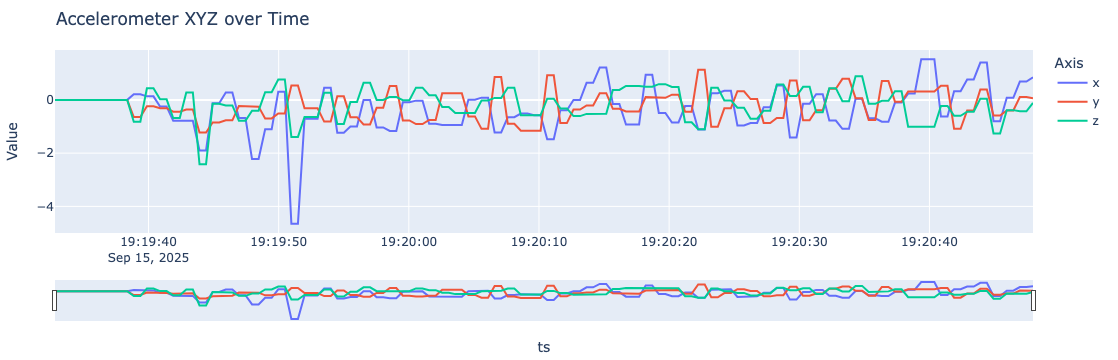

,Min,Max,Mean,Std
Axis,,,,
x,-4.655899,1.529449,-0.355677,0.889629
y,-1.222946,1.128479,-0.228472,0.558365
z,-2.416489,0.886337,-0.174795,0.571190


,ts,x,y,z
0,2025-09-15 19:19:32.815172,0.0,0.0,0.0
1,2025-09-15 19:19:33.320269,0.0,0.0,0.0
2,2025-09-15 19:19:33.823835,0.0,0.0,0.0
3,2025-09-15 19:19:34.327569,0.0,0.0,0.0
4,2025-09-15 19:19:34.832390,0.0,0.0,0.0


In [24]:
res = plot_xyz_csv("fasta.csv")         
res["stats"]    
res["fig"]     
res["df"].head()